## Implosion Year Prediction (predict implosions one year ahead)

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("when_approach").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-03-01 22:53:18,245 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-03-01 22:53:19,270 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-03-01 22:53:19,270 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2024-03-01 22:53:

[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

In [3]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    plt.title('Percentage of Null Values in Each Column')
    plt.ylabel('Percentage of Null Values')
    plt.xlabel('Columns')
    plt.show()
    
def plot_nulls_per_year(df):
    # Extract year from the date_column
    df = df.withColumn('Year', F.year('date'))
    
    # Group by year and sum null values for each column
    nulls_per_year = df.groupBy('Year').agg(*[
        (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns
    ]).toPandas()

    # Plot
    nulls_per_year.plot(kind='bar', x='Year', figsize=(20, 6))
    plt.title('Total Null Values per Year')
    plt.ylabel('Total Null Values')
    plt.xlabel('Year')
    plt.show()



def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df



df = get_df(f'{main_dir}/data/imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-03-01 22:54:15,295 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_div_yld_secs', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_free_ps_cf', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr', 'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_cf_debt', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_basic_beft_xord', 'ff_net_inc_bef_xord_gr', 'ff_net_inc_dil', 'ff_net_inc_dil_aft_xord', 'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_i

In [5]:
df = df.toPandas()
df.head()

,fsym_id,date,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,...,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,GDP,Unemployment_Rate,CPI,label
0,B00FG1-R,2012-12-31,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,NaN,...,0.0,-0.590,0.000000,NaN,0.0,NaN,0.006181,7.9,-0.000121,0
1,B00FG1-R,2013-12-31,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,NaN,...,0.0,-8.890,0.000000,-32.489870,0.0,NaN,0.014049,6.7,0.002644,0
2,B00FG1-R,2014-12-31,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,1.472874,...,0.0,14.392,0.294125,3.610653,0.0,-95.4447,0.006058,5.6,-0.003085,0
3,B00FG1-R,2015-12-31,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,0.060456,...,0.0,75.952,1.071870,19.546902,0.0,-11.9743,0.001821,5.0,-0.001076,0
4,B00FG1-R,2016-12-31,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,0.426602,...,0.0,85.144,0.710952,21.835781,0.0,-22.8867,0.010414,4.7,0.002525,0


In [6]:
# df=df.toPandas()
print(len(df[df['label']==1]))

667


The implosion number is 667, not 711, because not all the imploded stocks have fundamental data available

In [7]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,...,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,GDP,Unemployment_Rate,CPI,label
152,B0CXCV-R,2015-12-31,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,5.968216,...,0.000000,-8.96146,0.0,NaN,0.000,NaN,0.001821,5.0,-0.001076,0
153,B0CXCV-R,2016-12-31,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,0.000000,...,0.568103,-10.17350,0.0,NaN,0.000,NaN,0.010414,4.7,0.002525,0
154,B0CXCV-R,2017-12-31,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,21.757298,...,-4.730520,-21.53830,0.0,NaN,0.000,NaN,0.017494,4.1,0.002107,0
155,B0CXCV-R,2018-12-31,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,25.673647,...,-22.345200,-44.93320,0.0,NaN,0.000,-43.4143,0.005728,3.9,0.000685,0
156,B0CXCV-R,2019-12-31,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,3.690083,...,0.000000,0.00000,0.0,-447.654602,0.000,-95.6397,0.009593,3.6,0.003154,0
157,B0CXCV-R,2020-12-31,1.544423,1.427903,167.621980,0.041000,0.297342,82.302726,0.460218,0.993264,...,0.000000,0.00000,0.0,-202.630768,0.039,-53.4781,0.017409,6.7,0.004685,1


### IMPORTANT - Convert to Prediction Task by shifting label backwards for each stock

In [8]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-03-01 22:55:52,526 WARN scheduler.TaskSetManager: Stage 22 contains a task of very large size (7611 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,...,ff_bk_oper_inc_tot,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,GDP,Unemployment_Rate,CPI,label
58119,B0CXCV-R,2015-12-31,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,5.968216,...,0.000000,-8.96146,0.0,NaN,0.0,NaN,0.001821,5.0,-0.001076,0
58118,B0CXCV-R,2016-12-31,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,0.000000,...,0.568103,-10.17350,0.0,NaN,0.0,NaN,0.010414,4.7,0.002525,0
58117,B0CXCV-R,2017-12-31,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,21.757298,...,-4.730520,-21.53830,0.0,NaN,0.0,NaN,0.017494,4.1,0.002107,0
58116,B0CXCV-R,2018-12-31,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,25.673647,...,-22.345200,-44.93320,0.0,NaN,0.0,-43.4143,0.005728,3.9,0.000685,0
58115,B0CXCV-R,2019-12-31,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,3.690083,...,0.000000,0.00000,0.0,-447.654602,0.0,-95.6397,0.009593,3.6,0.003154,1


## Feature Selection

### Drop Highly Correlated Variables

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_when.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.8:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_assets_com_eq - ff_assets_eq: 0.9978347013149328
ff_assets_com_eq - ff_debt_com_eq: 0.9987533821114919
ff_assets_com_eq - ff_debt_eq: 0.997782711996142
ff_assets_com_eq - ff_ltd_com_eq: 0.9986969908494957
ff_assets_eq - ff_debt_com_eq: 0.9997877137681472
ff_assets_eq - ff_debt_eq: 0.9955515391249006
ff_assets_eq - ff_ltd_com_eq: 0.9997798728291207
ff_assets_gr - ff_com_eq_gr: 0.9999999946474392
ff_assets_gr - ff_debt_lt_cf: 0.9986618483738712
ff_assets_gr - ff_debt_st_x_curr_port: 0.9580776120461145
ff_assets_gr - ff_inc_tax_curr: 0.9894113489565998
ff_assets_gr - ff_inc_tax_dfd: 0.9669849138600688
ff_assets_gr - ff_int_exp_oth: 0.9980079978513435
ff_assets_gr - ff_invest_cap: 0.9986142550892115
ff_assets_gr - ff_net_inc_basic_aft_xord: 0.9984577802610156
ff_assets_gr - ff_net_inc_basic_beft_xord: 0.9985972321052696
ff_assets_gr - ff_net_inc_bef_xord_gr: 0.9999999946603256
ff_assets_gr - ff_oper_inc_aft_unusual:

In [11]:
df.columns #features

Index(['fsym_id', 'date', 'ff_assets_com_eq', 'ff_assets_gr',
       'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr',
       'ff_capex_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr',
       'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_invest_lt',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg',
       'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap',
       'ff_reinvest_rate', 'ff_roic', 'ff_tcap_assets', 'ff_xord',
       'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt',
       'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_oper_inc',
       'ff_commiss_inc_net', 'ff_cf_roic', 'ff_liab

In [12]:
feats = df.columns[2:-1]

In [13]:

# Assuming df is your DataFrame
null_values_per_column = df.isnull().sum()
total_rows = len(df)

print("Proportion of null values per column:")
for column, null_count in null_values_per_column.items():
    proportion_null = null_count / total_rows
    print(f"Column '{column}': {proportion_null:.2%}")


Proportion of null values per column:
Column 'fsym_id': 0.00%
Column 'date': 0.00%
Column 'ff_assets_com_eq': 8.87%
Column 'ff_assets_gr': 7.83%
Column 'ff_assets_oth_tot': 5.81%
Column 'ff_assets_per_emp': 16.30%
Column 'ff_bps_gr': 11.82%
Column 'ff_capex_assets': 2.87%
Column 'ff_cash_div_cf': 2.47%
Column 'ff_cash_roce': 14.20%
Column 'ff_cf_ps_gr': 17.19%
Column 'ff_cf_sales': 7.48%
Column 'ff_com_eq_tcap': 3.60%
Column 'ff_debt_entrpr_val': 15.68%
Column 'ff_dfd_tax_assets_lt': 0.00%
Column 'ff_dil_adj': 0.90%
Column 'ff_div_yld': 15.99%
Column 'ff_earn_yld': 15.84%
Column 'ff_ebit_oper_roa': 20.83%
Column 'ff_entrpr_val_sales': 19.17%
Column 'ff_eps_basic_gr': 19.27%
Column 'ff_fix_assets_com_eq': 10.33%
Column 'ff_for_assets_pct': 18.45%
Column 'ff_for_sales_pct': 11.69%
Column 'ff_gross_cf_debt': 17.94%
Column 'ff_inc_adj': 0.07%
Column 'ff_inc_sund': 0.05%
Column 'ff_invest_lt': 3.40%
Column 'ff_invest_st_tot': 20.64%
Column 'ff_ltd_tcap': 3.83%
Column 'ff_min_int_tcap': 4.55

### Drop columns with low variance

In [14]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date' ], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)

Index(['ff_assets_com_eq', 'ff_assets_gr', 'ff_assets_oth_tot',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_div_cf',
       'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap',
       'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj',
       'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales',
       'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct',
       'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund',
       'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg',
       'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap',
       'ff_reinvest_rate', 'ff_roic', 'ff_tcap_assets', 'ff_xord',
       'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt',
       'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_oper_inc',
       'ff_commiss_inc_net', 'ff_cf_roic', 'ff_liabs_lease',
       'Unemploy

In [15]:
df = df[remaining_feats.tolist()+['fsym_id', 'label', 'date']]

In [16]:
rows_with_null_count = df.isnull().any(axis=1).sum()

print(rows_with_null_count)

75701


In [17]:
print(len(df))

103643


In [18]:
split_date = '2019-01-01'
df=df.reset_index()
df['date'] = pd.to_datetime(df['date'])
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

In [19]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

# train_df = train_df.reset_index()
# test_df = test_df.reset_index()
feats = train_df.drop(['fsym_id', 'label', 'date'], axis=1).columns.tolist()

test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df[feats] = test_df.groupby(['year'])[feats].fillna(test_df.median())

train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year





In [20]:
print(len(test_df))
print(len(train_df))

18281
85362


In [21]:
mask = (train_df['label'] == 0) & (train_df.isnull().any(axis=1)) #remove the null values with majority class only - this is fine to do for the training set, but not the test set

train_df = train_df[~mask]

In [22]:
null_rows = test_df[test_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

Empty DataFrame
Columns: [index, ff_assets_com_eq, ff_assets_gr, ff_assets_oth_tot, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_tcap, ff_debt_entrpr_val, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_entrpr_val_sales, ff_eps_basic_gr, ff_fix_assets_com_eq, ff_for_assets_pct, ff_for_sales_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_invest_lt, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_net_inc_per_emp, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_oper_ps_net_cf, ff_pfd_stk_tcap, ff_reinvest_rate, ff_roic, ff_tcap_assets, ff_xord, ff_xord_disc, ff_eps_dil_aft_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_bk_non_oper_inc, ff_commiss_inc_net, ff_cf_roic, ff_liabs_lease, Unemployment_Rate, fsym_id, label, date, year]
Index: []

[0 rows x 54 columns]


In [23]:
null_rows = train_df[train_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

         index  ff_assets_com_eq  ff_assets_gr  ff_assets_oth_tot  \
19          19          1.744019      9.876688                NaN   
1417      1417          1.960773      7.126562           0.021728   
1622      1622         18.473399     -8.626586          31.849000   
1895      1895          1.736805      2.951708           2.078000   
1950      1950          2.434970     -7.858710           0.543000   
...        ...               ...           ...                ...   
101533  101533          1.534106    -10.808998          24.119000   
101983  101983          1.158660      7.114621           0.249000   
102183  102183          3.751150   1016.200122          19.695000   
103333  103333          9.914593           NaN           0.000000   
103609  103609          2.498863     69.094266           0.000000   

        ff_assets_per_emp   ff_bps_gr  ff_capex_assets  ff_cash_div_cf  \
19               0.595847  -27.838054         5.640216             0.0   
1417             0.0757

In [24]:
train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.loc[train_df['label'] == 1].median())) #impute the stocks that do implode as we dont want to drop these even if they have null values due to their rarity

In [25]:
exclude_columns = ['fsym_id', 'label', 'year', 'date']
feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
print(feats)

['index', 'ff_assets_com_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_reinvest_rate', 'ff_roic', 'ff_tcap_assets', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_oper_inc', 'ff_commiss_inc_net', 'ff_cf_roic', 'ff_liabs_lease', 'Unemployment_Rate']


In [26]:
print(len(train_df.columns))
print(len(train_df['fsym_id']))
print(len(test_df['fsym_id']))
print(len(test_df[test_df['label']==1]))
print(len(train_df[train_df['label']==1]))

54
57276
18281
147
479


In [27]:
print(len(test_df)/(len(test_df)+len(train_df)))

0.2419497862540863


In [28]:
print(feats)
def create_lags(group):
    # for col in feats:
    #     group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
    #     # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
    # return group
    num_rows = len(group)
    for col in feats:
        if num_rows == 1:  # If only one row in the group, set lagged feature to original value
            group[f'{col}_lag1'] = group[col]
            # group[f'{col}_lag2'] = group[col]
        else:
            group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
            # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
    return group

# train_df = train_df.sort_values(by=['fsym_id', 'date'])
# test_df = test_df.sort_values(by=['fsym_id', 'date'])
# train_df2 = train_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)
# test_df2 = test_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)

['index', 'ff_assets_com_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_reinvest_rate', 'ff_roic', 'ff_tcap_assets', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_oper_inc', 'ff_commiss_inc_net', 'ff_cf_roic', 'ff_liabs_lease', 'Unemployment_Rate']


In [29]:
train_df2[['fsym_id', 'date', 'ff_tang_assets_debt', 'ff_tang_assets_debt_lag1']].head(100)

NameError: name 'train_df2' is not defined

In [30]:
null_rows = train_df2[train_df2.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

Empty DataFrame
Columns: [index, ff_assets_com_eq, ff_assets_gr, ff_assets_oth_tot, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_tcap, ff_debt_entrpr_val, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_entrpr_val_sales, ff_eps_basic_gr, ff_fix_assets_com_eq, ff_for_assets_pct, ff_for_sales_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_invest_lt, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_net_inc_per_emp, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_oper_ps_net_cf, ff_pfd_stk_tcap, ff_reinvest_rate, ff_roic, ff_tcap_assets, ff_xord, ff_xord_disc, ff_eps_dil_aft_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_bk_non_oper_inc, ff_commiss_inc_net, ff_cf_roic, ff_liabs_lease, Unemployment_Rate, fsym_id, label, date, year, index_lag1, ff_assets_com_eq_lag1, ff_assets_gr_lag1, ff_assets_oth_tot_lag1, ff_assets_per_emp_lag1, ff_bps_gr_lag1, ff_capex_ass

In [38]:
test_df2.head()

,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,ff_cf_ps_gr,ff_cf_sales,...,ff_xord_disc_lag1,ff_eps_dil_aft_xord_lag1,ff_std_debt_lag1,ff_tang_assets_debt_lag1,ff_bk_oper_inc_oth_lag1,ff_bk_non_oper_inc_lag1,ff_commiss_inc_net_lag1,ff_cf_roic_lag1,ff_liabs_lease_lag1,Unemployment_Rate_lag1
0,9.259366,1.740884,0.360,10.576109,223.385786,3.262686,78.776551,244.241893,-14.363112,46.233819,...,0.0,1.708835,0.000000,118.335154,0.0,0.0,0.0,18.576774,0.000,3.6
1,5.582877,-4.054462,0.266,10.258813,58.529332,1.318405,43.728272,148.525156,17.535225,56.131629,...,0.0,1.708835,0.000000,118.335154,0.0,0.0,0.0,18.576774,0.000,3.6
2,3.629757,-9.429794,4.033,0.258975,-28.845197,5.212495,-0.118653,-52.582749,54.454300,-4.446636,...,0.0,-3.460347,23.450652,1345.494904,0.0,0.0,0.0,-54.225962,21.554,3.6
3,2.221653,98.745592,2.564,0.474408,199.626566,2.304466,0.000000,41.148911,-59.157947,3.943983,...,0.0,-3.460347,23.450652,1345.494904,0.0,0.0,0.0,-54.225962,21.554,3.6
4,1.432007,28.396534,3.236,0.789604,98.017201,1.277433,0.000000,22.271076,-59.157947,4.516831,...,0.0,1.237941,13.390662,1097.763071,0.0,0.0,0.0,70.845798,20.305,6.7


In [30]:
import os
import pandas as pd

train_file = 'data_when/train_df_when.csv'
test_file = 'data_when/test_df_when.csv'

# Check if the files exist
if not (os.path.exists(train_file) and os.path.exists(test_file)):
    # Write DataFrames to files
    train_df.to_csv(train_file, index=False)
    test_df.to_csv(test_file, index=False)
else:
    # Read DataFrames from existing files
    print("works")
    train_df = pd.read_csv(train_file, index_col=False)
    test_df = pd.read_csv(test_file, index_col=False)

In [31]:
train_df.head()

,index,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,ff_cf_ps_gr,...,ff_bk_oper_inc_oth,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,Unemployment_Rate,fsym_id,label,date,year
3,3,1.205895,61.679445,3.439,1.230111,79.509394,7.637973,0.0,18.571861,-106.093041,...,-0.045552,28.954,0.045552,14.742053,0.0,3.9,BHZYXG-R,0,2018-12-31,2018
4,4,1.563511,-2.352477,4.193,0.752473,-2.043736,0.810028,0.0,-1.489816,76.230929,...,-0.003600,-13.959,0.003600,-1.509609,0.0,4.1,BHZYXG-R,0,2017-12-31,2017
5,5,1.601873,-1.256043,2.465,1.481507,-3.935307,0.668809,0.0,2.273441,-163.293120,...,-0.003600,-17.241,0.003600,-6.130346,0.0,4.7,BHZYXG-R,0,2016-12-31,2016
6,6,1.601555,24.079812,3.181,1.805508,-19.847899,1.186107,0.0,-11.700086,-163.293120,...,-0.003600,-39.545,0.003600,8.473203,0.0,5.0,BHZYXG-R,0,2015-12-31,2015
7,7,1.067698,19.780396,0.028,2.682875,192.886340,5.107045,0.0,-47.422429,-70.414663,...,-0.003600,-56.706,0.003600,-79.587784,0.0,5.6,BHZYXG-R,0,2014-12-31,2014


In [33]:
train_df.drop([ 'index' ], axis=1, inplace=True)
test_df.drop([ 'index' ], axis=1, inplace=True)

# train_df2.drop([ 'index' ], axis=1, inplace=True)
# test_df2.drop([ 'index' ], axis=1, inplace=True)



In [34]:
train_df = train_df.sort_values(by='date')
test_df=test_df.sort_values(by='date')

train_df2 = train_df2.sort_values(by='date')
test_df2=test_df2.sort_values(by='date')

NameError: name 'train_df2' is not defined

{0: 0.5042167720126063, 1: 59.78705636743215}
Estimate: 118.574
 36%|███▌      | 36/100 [06:32<11:38, 10.91s/trial, best loss: -0.23382208016727538]
Best params:{'colsample_bytree': 0.8, 'eta': 0.125, 'gamma': 4.3500000000000005, 'max_depth': 870.0, 'min_child_weight': 8.0, 'n_estimators': 646.0, 'subsample': 0.9500000000000001}


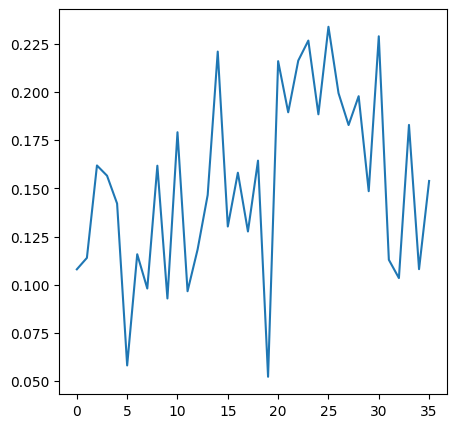

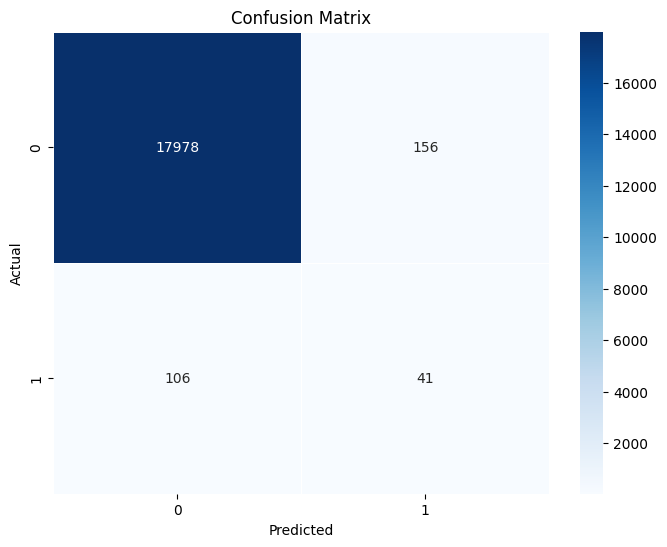

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
# import lightgbm
import datetime
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

current_date = datetime.datetime.now()
current_date= current_date.strftime("%Y-%m-%d") 

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Top 20 Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_when/{model_name}_top20_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(train_df, test_df, classifier):
    seed = 42

    train_df = train_df.set_index('date')
    test_df = test_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.sort_index()
    
    exclude_columns = ['fsym_id', 'label']
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,1000,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 5, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=seed)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        classifier_instance.fit(X_train, y_train)
        # scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        y_pred = classifier_instance.predict(X_test)
        score = matthews_corrcoef(y_test, y_pred)
        obj_scores.append(score)
        return -score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        # res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10))
    print(f"Best params:{best_params}")
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    all_reports = []
    plt.figure(figsize=(5,5))
    plt.plot(obj_scores)
    plt.show()
    
    classifier_instance.fit(X_train, y_train)
    preds = classifier_instance.predict(X_test)
    final_report = classification_report(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    filename = f'results_when/report_{classifier}_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_params))
    
#     for train_index, test_index in tscv.split(X_train):
#         x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
#         Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
#         classifier_instance.fit(x_train, Y_train)
        
#         preds = classifier_instance.predict(x_test)
#         report = classification_report(Y_test, preds)
#         print(report)
#         all_reports.append(report)
    cm = confusion_matrix(y_test, preds, labels=classifier_instance.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    test_df_full = test_df.copy()
    test_df_full['preds'] = preds

    return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df_full


model, feats, X_train, X_test, test_df_with_preds = model_testing(train_df, test_df, 'XGB')

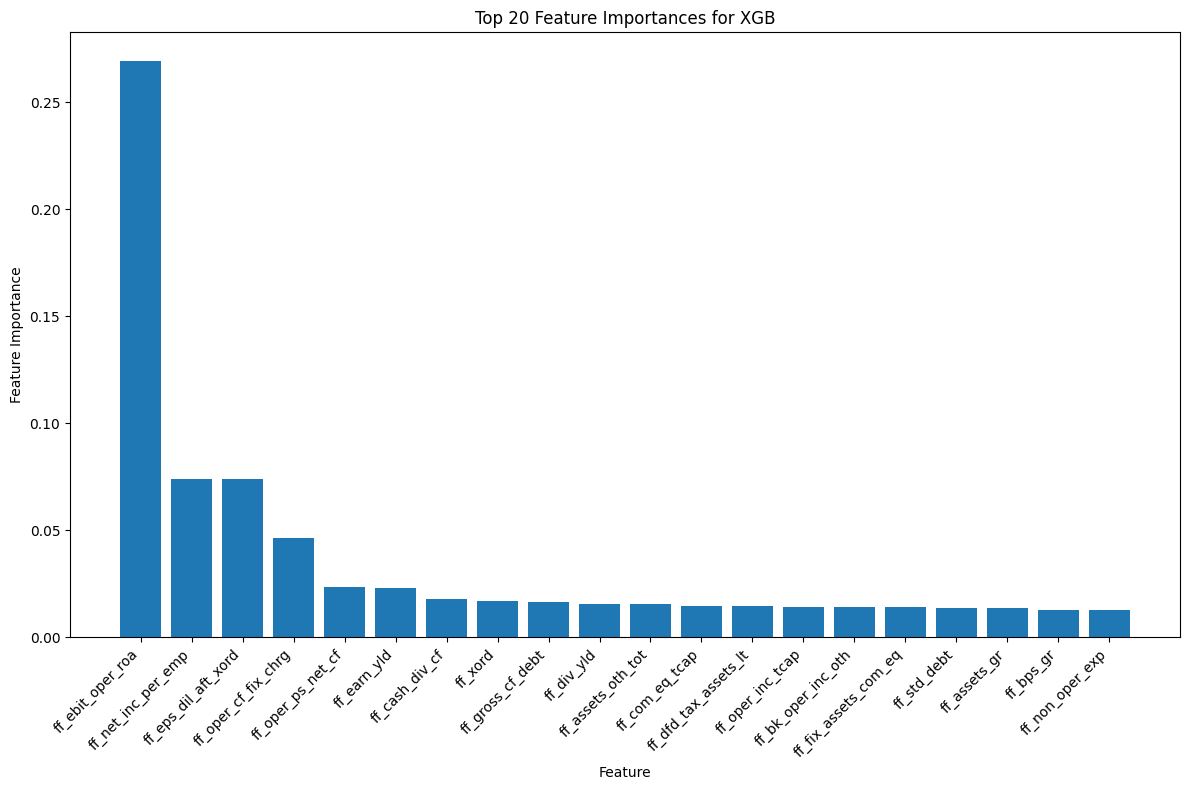

['ff_ebit_oper_roa', 'ff_net_inc_per_emp', 'ff_eps_dil_aft_xord', 'ff_oper_cf_fix_chrg', 'ff_oper_ps_net_cf', 'ff_earn_yld', 'ff_cash_div_cf', 'ff_xord', 'ff_gross_cf_debt', 'ff_div_yld', 'ff_assets_oth_tot', 'ff_com_eq_tcap', 'ff_dfd_tax_assets_lt', 'ff_oper_inc_tcap', 'ff_bk_oper_inc_oth', 'ff_fix_assets_com_eq', 'ff_std_debt', 'ff_assets_gr', 'ff_bps_gr', 'ff_non_oper_exp']
{0: 0.5042167720126063, 1: 59.78705636743215}
Estimate: 118.574
  8%|▊         | 8/100 [01:08<13:03,  8.52s/trial, best loss: -0.05660486707985108] 


KeyboardInterrupt: 

In [37]:
feats_to_drop = feature_importances(model,feats, 'XGB')
print(feats_to_drop)
train_df2 = train_df.drop(feats_to_drop, axis=1)
test_df2 = test_df.drop(feats_to_drop, axis=1)
model2, feats2, _,_,_ = model_testing(train_df2, test_df2, 'XGB')

In [34]:
_ = feature_importances(model2,feats2)

NameError: name 'model2' is not defined

In [66]:
len(X_train.columns)

64

100%|===================| 18260/18281 [01:32<00:00]        

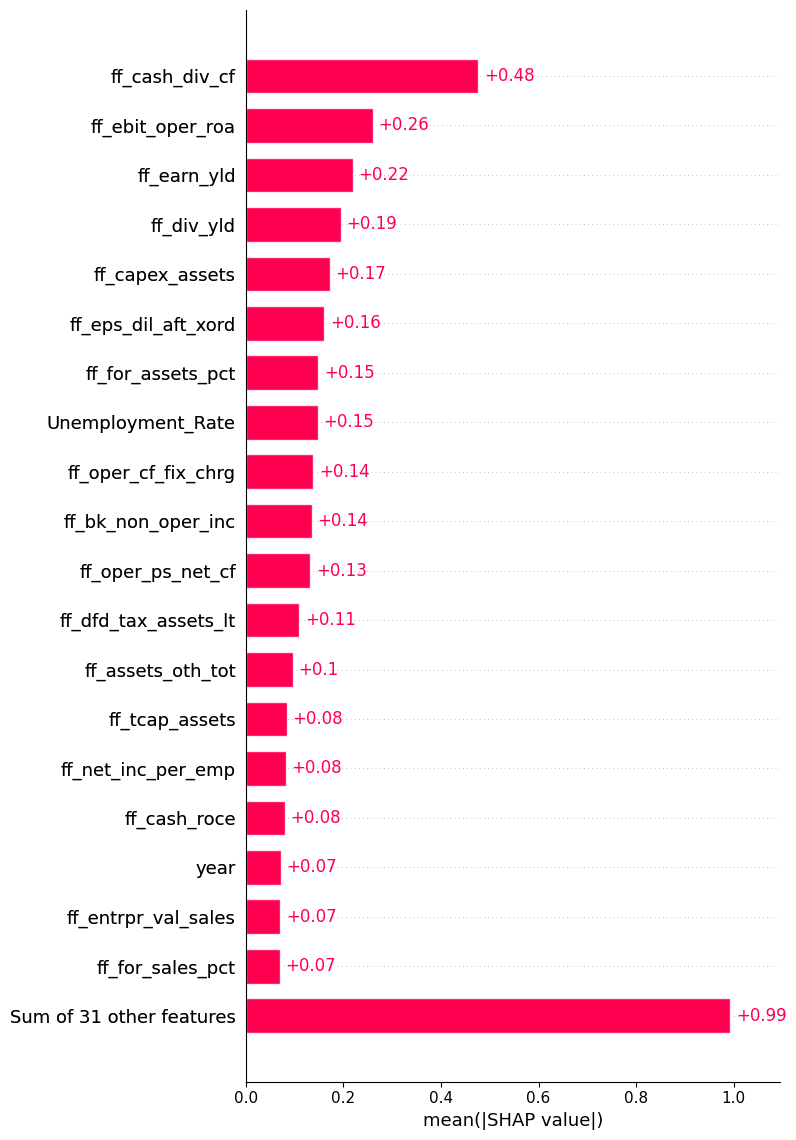

In [41]:
import shap


def shapley(model, train, test, model_name, plot_type):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model,train)
    shap_values = explainer(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.savefig(f'results_when/{model_name}_shap_{plot_type}.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
shapley(model, X_train, X_test, 'XGB', 'bar')

In [45]:
train_df.head()

,index,fsym_id,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_fix_assets,ff_cash_curr_assets,...,ff_std_debt,ff_bk_oper_inc_oth,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,48976,GJZ5YB-R,143.784000,1.729254,42.422,0.067783,40.774170,21.456759,38.323007,2.935040,...,16.327238,0.0,418.805,0.0,6.031711,47.160,258.142,0.011395,3.9,0
2000-01-31,87865,GSXP1N-R,6.019841,1.194269,0.000,0.184405,17.212545,2.732302,25.527204,70.773903,...,0.000000,0.0,0.000,0.0,-23.401890,0.000,14.350,0.011395,3.9,0
2000-01-31,70510,WPKF66-R,389.953000,2.733014,81.397,0.054461,4.659683,12.656485,33.016331,33.537477,...,51.517129,0.0,534.159,0.0,68.939663,0.018,570.000,0.011395,3.9,0
2000-01-31,89899,LWY6TY-R,6.947000,1.902163,1.656,0.276648,29.050884,6.648226,14.881759,14.276476,...,6.672323,0.0,0.000,0.0,5.554106,0.000,28.144,0.011395,3.9,0
2000-01-31,38583,BZNBHW-R,29.544000,2.373729,4.166,0.092724,-6.072055,5.046265,6.617032,3.564810,...,5.623622,0.0,0.000,0.0,7.655820,0.000,-7.665,0.011395,3.9,0


In [94]:
from sklearn.ensemble import IsolationForest

def anomaly_det(train_df, test_df):
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    exclude_columns = ['fsym_id', 'label', 'date']
    features = train_df.drop(exclude_columns, axis=1).columns
    print("Converted to Pandas")
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df.set_index('date', inplace=True)
    train_df.sort_index(inplace=True)
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df.set_index('date', inplace=True)
    test_df.sort_index(inplace=True)
    contam = len(train_df[train_df['label']==1])/len(train_df)
    isol_for = IsolationForest(contamination=contam, random_state=42)
    non_anomalies = train_df[train_df['label']==0]
    isol_for.fit(non_anomalies[features])
    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    cm = confusion_matrix(test_df['label'], test_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
# anomaly_det(train_df, test_df)

{0: 0.5055204769127659, 1: 45.78594249201278}
52130 499 5194 127
0.009664736301834169
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1057 (4.13 KB)
Trainable params: 1057 (4.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
163/163 [==============================] - 0s 2ms/step - loss: 0.3566 - cross entropy: 0.3566 - Brier score: 0.0863 - tp: 92.0000 - fp: 561.0000 - tn: 4506.0000 - fn: 35.0000 - accuracy: 0.8853 -

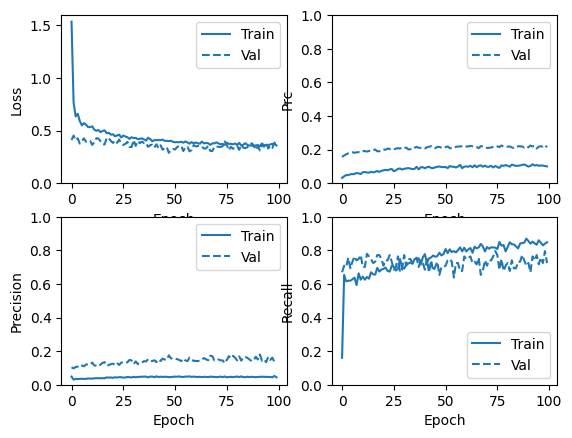

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Generate some dummy time series data


# Define the number of folds for cross-validation

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':#
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
    
def plot_loss(history, label, n):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def nn_training(df):
    df=df.set_index('date')
    df=df.sort_index()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    def make_model(train_features, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            
        model = keras.Sequential([
              keras.layers.Dense(
                  16, activation='relu',
                  input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid',
                                 bias_initializer=output_bias),
          ])
   
        
        model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=metrics)
        return model
    
    def get_preds(model, feats, truth):
        predictions = model.predict(feats, batch_size = 2048)
        print(predictions)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(classification_report(truth, predictions))
    
    
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
#         tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
#         tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    
    print(len(y_train), len(y_train[y_train==1]), len(y_test), len(y_test[y_test==1]))

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    pos = len(y_train[y_train==1])
    neg = len(y_train[y_train==0])
    print(pos/neg)
    initial_bias = np.log([pos/neg])

    model = make_model(X_train, output_bias=initial_bias)
    print(model.summary())

    fit_model = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_test, y_test), class_weight = class_weight_dict, 
                        
                         verbose=0)
    # plot_model_performance(fit_model, 'bin_cross_entropy', 'accuracy')
    plot_metrics(fit_model)
    # plot_loss(fit_model, "Train Loss", 0)

    results = model.evaluate(X_test, y_test)
    print(f'Test loss: {results[0]}')

    # Make predictions on new data
    get_preds(model, X_train, y_train)
    get_preds(model, X_test, y_test)
        

#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.title(f'Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()


    
nn_training(df)

In [68]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score

# Define the search space for hyperparameters

def hyperopt_nn(train_df, test_df):
    train_df = train_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.set_index('date')
    test_df = test_df.sort_index()
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = train_df.drop(['fsym_id', 'label'], axis=1)
    X_val = test_df.drop(['fsym_id', 'label'], axis=1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train = train_df['label']
    y_val = test_df['label']
    
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        y_true = tf.cast(y_true, tf.float32)
      
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

        focal_loss = -alpha * (1 - p_t) ** gamma * ce_loss

        return tf.reduce_mean(focal_loss)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >= 0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_when/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
    
hyperopt_nn(train_df, test_df)


 20%|██        | 10/50 [20:04<1:20:17, 120.43s/trial, best loss: -0.21117383503759812]
Best hyperparameters: {'learning_rate': 0.0007817282264531573, 'batch_size': 2048, 'num_layers': 5, 'num_neurons': 1024, 'dropout_rate': 0.22339292884825013, 'class_weight_0': 0.436465571376498, 'class_weight_1': 79.91672813771633}
Best metric: 0.15992929924178523
4/4 [==============================] - 0s 18ms/step
[[1.1429015e-01]
 [2.8441193e-02]
 [5.2132720e-10]
 ...
 [1.1065436e-09]
 [1.4811221e-03]
 [1.7400508e-01]]


In [1]:
from CreateDataset import get_fund_data
import math
from datetime import datetime, timedelta

def plot_prices(imp_df, pic_name):
    imp_df=imp_df.sort_values(by=['fsym_id', 'date'])
    imp_df['date'] = pd.to_datetime(imp_df['date'])
    list_to_plot = sorted(imp_df['fsym_id'].unique().tolist())
    
    columns = 5
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = imp_df[imp_df['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        
        imp_start_date = temp_df['Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_start_date + timedelta(days=365)
        
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            # imp_start_date = pd.to_datetime(imp_start_date)
            # imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)


def plot_true_false_positives(test_df, square, model_name):
    if square == 'FP':
        df = test_df[(test_df['label'] == 0) & (test_df['preds'] == 1)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_positives_{model_name}.png')
    elif square == 'FN':
        df = test_df[(test_df['label'] == 1) & (test_df['preds'] == 0)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_negatives_{model_name}.png')
        

        

plot_true_false_positives(test_df_with_preds, 'FN', 'XGB')

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-18 14:09:14,822 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-18 14:09:17,854 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


NameError: name 'test_df_with_preds' is not defined

In [78]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import matthews_corrcoef
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
import numpy as np

# Define the search space for hyperparameters
def hyperopt_rnn(df):
    df = df.set_index('date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [1, 2, 3]),
        'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'thresh': hp.uniform('thresh', 0, 1)
    }
    
    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    print(len(X_train) / len(X))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.LSTM(params['num_neurons'], return_sequences=True))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.LSTM(params['num_neurons']))
        model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)
        
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0)
        preds = (preds >= params['thresh']).astype(int)
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric

    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096][best['batch_size']],
        'num_layers': [1, 2, 3][best['num_layers']],
        'num_neurons': [64, 128, 256][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'thresh': best['thresh']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size=best_hyperparams['batch_size'])
    preds = (preds >= best_hyperparams['thresh']).astype(int)
    print(classification_report(y_val, preds))
    
# Example usage
# hyperopt_rnn(df)


In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   

    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()